##By : Omar Moured

### In this notebook we will learn how to use YOLO .onnx models after exporting them by ultralytics repo [https://github.com/ultralytics]

In [1]:
import onnxruntime # Inference Engine
from PIL import Image 
import numpy as np 
import torch
from utils.general import non_max_suppression
import cv2 # to drow rectangles boxes on the image
import matplotlib.pyplot as plt # to plot the image

#### Export YOLO from ultralytics

##### Please check the line model.model[-1].export in models/export.py : set it to False. 
##### That is,  model.model[-1].export = False (it means all detection layers output will be concatenated and returned as a single output). 

In [2]:
# RUN in Terminal

#git clone https://github.com/ultralytics/yolov5  # clone repo
#cd yolov5
#pip install -r requirements.txt  # base requirements
#pip install onnx>=1.8.0  # for ONNX export
#python models/export.py --weights yolov5s.pt --img 640 --batch 1  # export at 640x640 with batch size 1

#### Initialization

In [3]:
image_path='bus.jpg'
model_path = 'yolov5s.onnx'

# Model configs : can be found in the .yaml file when training
anchors = [[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]
num_classes = 80

# Thresholds for OpenCV Non-Maximum-Supprision (NMS) 
SCORE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.5

#### Inference Steps

In [4]:
# Load onnx model
session = onnxruntime.InferenceSession(model_path)

print("The model expects input shape: ", session.get_inputs()[0].shape)
batch_size = session.get_inputs()[0].shape[0]
img_size_h = session.get_inputs()[0].shape[2]
img_size_w = session.get_inputs()[0].shape[3]

The model expects input shape:  [1, 3, 640, 640]


In [5]:
# Load input image (critical step) : The input image should be the same as the expexted input when training.

image_src = Image.open(image_path)
print('Loaded Image Info : ',image_src.format, image_src.size, image_src.mode) # size order : width*height

# Resize to img_size_w, img_size_h
resized =  image_src.resize((img_size_w, img_size_h))   # To be imblemnated : letterbox_image(image_src, (img_size_w, img_size_h))
print('After resizing :' ,resized.size, resized.mode) # size order : width*height
#display(resized)

# Preprocess the image
img_in = np.transpose(resized, (2, 0, 1)).astype(np.float32)  # HWC -> CHW
img_in = np.expand_dims(img_in, axis=0) # Add redundant dimension for batch-size (Assumed to be 1, check batch_size = session.get_inputs()[0].shape[0])
img_in /= 255.0 # Normalize all pixels
print('Batch-Size, Channel, Height, Width : ',img_in.shape)

Loaded Image Info :  JPEG (810, 1080) RGB
After resizing : (640, 640) RGB
Batch-Size, Channel, Height, Width :  (1, 3, 640, 640)


In [6]:
# Feedforward the Image 
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_in})

print('Concatenated outputs shape: ', outputs[0].shape)
print('Separated outputs shape: ', outputs[1].shape, outputs[2].shape, outputs[3].shape)
# 3*80*80 + 3*40*40 + 3*20*20 = 25200
# 85 = 5 (x ,y ,w ,h ,confidence) + 80 (class scores)

Concatenated outputs shape:  (1, 25200, 85)
Separated outputs shape:  (1, 3, 80, 80, 85) (1, 3, 40, 40, 85) (1, 3, 20, 20, 85)


#### Output Parsing

##### Method (1) : PyTorch NMSoutputs[0]

In [7]:
filterd_predictions = non_max_suppression(torch.tensor(outputs[0]), conf_thres = SCORE_THRESHOLD, iou_thres = NMS_THRESHOLD)
print(filterd_predictions) # x1, y1, x2, y2, conf, class_indx

[tensor([[529.29089, 231.74194, 639.90552, 524.68024,   0.88853,   0.00000],
        [ 43.06931, 235.58731, 185.83316, 534.68469,   0.87094,   0.00000],
        [175.91522, 241.11502, 269.94348, 506.25870,   0.85376,   0.00000],
        [ 15.84814, 135.88441, 641.58289, 451.74225,   0.72653,   5.00000]])]


In [8]:
# If you didn't change model.model[-1].export to False, uncomment this cell and run it.
# It will automatically reshape the outputs to non_max_suppression function format

# NOT READY 

#### Plot Output

Confidence:  0.88853115 Class: 0
Confidence:  0.870942 Class: 0
Confidence:  0.85375684 Class: 0
Confidence:  0.726528 Class: 5


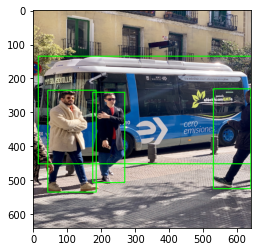

In [9]:
img = cv2.resize(cv2.imread(image_path),(img_size_w,img_size_h)) # Load Image and Resize it to img_size_w*img_size_h
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # BGR TO RGB
for pred in filterd_predictions[0]:
    pred = pred.detach().cpu().numpy()
    x1 = int(pred[0])
    y1 = int(pred[1])
    x2 = int(pred[2])
    y2 = int(pred[3])
    img = cv2.rectangle(img, (x1,y1),(x2,y2), thickness = 2, color=(0,255,0))
    print('Confidence: ', pred[4], 'Class:', int(pred[5]))
plt.imshow(img)

##### Method (2) : Without PyTorch

In [10]:
# NOT READY